In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Importing Word_List

In [2]:
l1 = []
with open(r"C:\Users\khush\Python, 12-7\words_250000_train.txt","r") as file:
    words = file.read().splitlines()
    l1.append(words)
    file.close()
all_words = l1[0]
print(f"Number of words in the game: {len(all_words)}")

Number of words in the game: 227300


# Original Hangman Game

In [7]:
import random

class HangmanGame:
    def __init__(self, word_list):
        self.word_list = word_list
        self.target_word = ""
        self.guesses_left = 6
        self.guessed_letters = set()
        self.word_in_progress = []

    def choose_word(self):
        self.target_word = random.choice(self.word_list)
        self.word_in_progress = ["_"] * len(self.target_word)

    def display_word(self):
        return " ".join(self.word_in_progress)

    def make_guess(self, letter):
        if letter in self.guessed_letters:
            return "You already guessed that letter!"

        self.guessed_letters.add(letter)

        if letter in self.target_word:
            for i in range(len(self.target_word)):
                if self.target_word[i] == letter:
                    self.word_in_progress[i] = letter
            if "_" not in self.word_in_progress:
                return "Congratulations! You guessed the word: {}".format(self.target_word)
        else:
            self.guesses_left -= 1
            if self.guesses_left == 0:
                return "Sorry, you ran out of guesses. The word was: {}".format(self.target_word)

        return self.display_word() + f"\nLives left: {self.guesses_left}"

# Example usage:
word_list = all_words

custom_hangman = HangmanGame(word_list)
custom_hangman.choose_word()

print("Welcome to Hangman!")
print("Word to guess:", custom_hangman.display_word())

while custom_hangman.guesses_left > 0 and "_" in custom_hangman.word_in_progress:
    guess = input("Enter your guess: ").lower()
    result = custom_hangman.make_guess(guess)
    print(result)

print("Game over.")


Welcome to Hangman!
Word to guess: _ _ _ _ _ _ _ _ _
Enter your guess: c
c _ _ _ _ _ _ _ _
Lives left: 6
Enter your guess: h
c h _ _ _ _ _ _ _
Lives left: 6
Enter your guess: a
c h a _ _ _ _ _ _
Lives left: 6
Enter your guess: e
c h a _ _ e _ _ e
Lives left: 6
Enter your guess: l
c h a l l e _ _ e
Lives left: 6
Enter your guess: n
c h a l l e n _ e
Lives left: 6
Enter your guess: g
Congratulations! You guessed the word: challenge
Game over.


## Model - 1 -- cosine similarity

In [21]:
import random

class HangmanGame:
    def __init__(self, word_list):
        self.word_list = word_list
        self.target_word = ""
        self.guesses_left = 6
        self.guessed_letters = set()
        self.word_in_progress = []
        self.common_letters = ''
        

    def choose_word(self):
        self.target_word = random.choice(self.word_list)
        self.word_in_progress = ["_"] * len(self.target_word)

    def display_word(self):
        return " ".join(self.word_in_progress)
    
    
    def guess_here(self):
        
        #Guessing the first word using random guess, based on MOST COMMON LETTERS
        random_guess_char = "eariotns"
        """
        Most Common Letters in percentage
        E – 11.1607%
        A – 8.4966%
        R – 7.5809%
        I – 7.5448%
        O – 7.1635%
        T – 6.9509%
        N – 6.6544%
        S – 5.7351%
        
        """
        if len(re.findall(r"[a-zA-Z]+","".join(self.word_in_progress)))== 0:
            for char in range(len(random_guess_char)):
                if random_guess_char[char] in self.common_letters:
                    continue
                else:
                    self.common_letters += random_guess_char[char]
                    left_guesses = self.guesses_left
                    return random_guess_char[char]
        
        #predicted_char = len(re.findall(r"[a-zA-Z]+","".join(self.word_in_progress)))

        #first take the incomplete word from word_in_progress
        incomplete_word = "".join(self.word_in_progress)
        #Find all the same length words from the final_list to predict the next letter
        words_with_same_length = [char for char in self.word_list if len(char) == len(self.word_in_progress)]
        
        # Convert them into vectors using CountVectorizer
        vectorizer = CountVectorizer(analyzer = 'char')
        
        words_with_same_length_vector = vectorizer.fit_transform(words_with_same_length)
        
        incomplete_word_vector = vectorizer.transform([incomplete_word])
        similarities = cosine_similarity(words_with_same_length_vector, incomplete_word_vector)
        
        similar_dic = {}
        for i,j in enumerate(similarities.tolist()):
            similar_dic[i] = j[0]

        sorted_list = sorted(similar_dic.items(),key = lambda x:x[1],reverse = True)

        similar_values = [words_with_same_length[sorted_list[i][0]] for i in range(len(sorted_list))]
        
        def count_sorted_list(word):
            new_dic = {}
            for i in word:
                if i not in new_dic:
                    new_dic[i] = 1
                else:
                    new_dic[i] +=1
            new_list = list(dict((sorted(new_dic.items(),reverse = True,key = lambda x:x[1]))).keys())
            return new_list
        
        previous_guesses_left = self.guesses_left

        while True:
            current_guesses_left = self.guesses_left  # Record current value
            # logic to check guessed letters and return i for each similar_value
            for similar_word in similar_values:
                for i in count_sorted_list(similar_word):
                    if i not in self.guessed_letters:
                        
                        if current_guesses_left != previous_guesses_left:
                            
                            break  # Break the loop if guesses_left changes
                        return i
                if current_guesses_left == previous_guesses_left:
                    previous_guesses_left = current_guesses_left  # Update previous value
                else:
                    break  # Break if guesses_left changes


        
        
        

    def make_guess(self, letter):
        if letter in self.guessed_letters:
            return "You already guessed that letter!"

        self.guessed_letters.add(letter)

        if letter in self.target_word:
            for i in range(len(self.target_word)):
                if self.target_word[i] == letter:
                    self.word_in_progress[i] = letter
            if "_" not in self.word_in_progress:
                return "Congratulations! You guessed the word: {}".format(self.target_word)
        else:
            self.guesses_left -= 1
            if self.guesses_left == 0:
                return "Sorry, you ran out of guesses. The word was: {}".format(self.target_word)

        return self.display_word() + f"\nLives left: {self.guesses_left}"

# Example usage:
word_list = all_words
#word_list = ['aion']
custom_hangman = HangmanGame(word_list)
custom_hangman.choose_word()

print("Welcome to Hangman!")
print("Word to guess:", custom_hangman.display_word())

while custom_hangman.guesses_left > 0 and "_" in custom_hangman.word_in_progress:
    #guess = input("Enter your guess: ").lower()
    guess = custom_hangman.guess_here()
    result = custom_hangman.make_guess(guess)
    print(result)

print("Game over.")


Welcome to Hangman!
Word to guess: _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ e
Lives left: 6
_ _ _ _ _ _ _ _ _ s _ _ _ _ _ _ _ e
Lives left: 6
_ _ _ p _ _ _ _ _ s _ _ _ _ _ _ _ e
Lives left: 6
n _ n p _ _ _ n _ s _ _ _ _ _ _ _ e
Lives left: 6
n _ n p _ _ _ n _ s t _ _ _ t _ _ e
Lives left: 6
n _ n p r _ _ n _ s t _ _ _ t _ _ e
Lives left: 6
n _ n p r _ _ n _ s t _ _ a t _ _ e
Lives left: 6
n o n p r o _ n o s t _ _ a t _ _ e
Lives left: 6
n o n p r o _ n o s t i _ a t i _ e
Lives left: 6
n o n p r o g n o s t i _ a t i _ e
Lives left: 6
n o n p r o g n o s t i c a t i _ e
Lives left: 6
Congratulations! You guessed the word: nonprognosticative
Game over.


## Practicing

In [67]:
l1 = ['abandond', 'nansomia', 'thermals', 'watererd', 'kanununa']
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(7)} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(0, 7):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy
    

In [63]:
entrophy(letter = "a",position = 1)

0.44217935649972373

In [ ]:
l1 = ['abandond', 'nansomia', 'thermals', 'watererd', 'kanununa']
all_letters = list(set("".join(l1)))

## Step 1

In [ ]:
# Find entrophy of each letter in each position

Text(0.5, 23.52222222222222, 'Index')

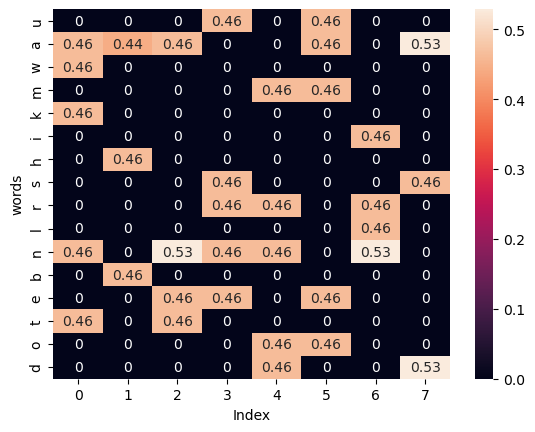

In [157]:
l1 = ['abandond', 'nansomia', 'thermals', 'watererd', 'kanununa']
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [ ]:
#Since on 7th position it had "a" and "d" have highest entrophy

In [88]:
# We selected "a" and gave it to the machine

In [ ]:
# It accepted the word but not on 7th position

In [ ]:
# From the list ['abandond', 'nansomia', 'thermals', 'watererd', 'kanununa']
# We sucessfully eliminated nansomia, kanununa

In [ ]:
# We are left wth 3 words now
#['abandond', 'thermals', 'watererd']

## Now finding the entrophy from filtered word list

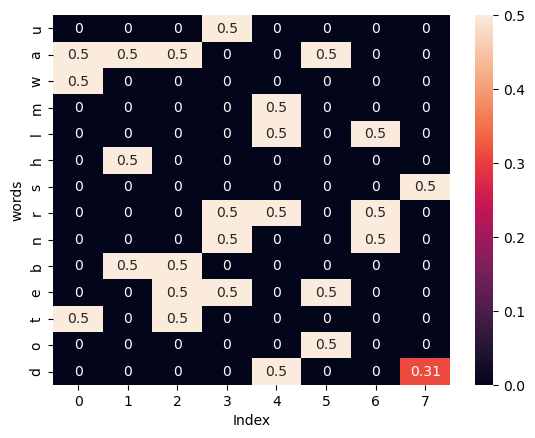

In [163]:
l1 = ['abandond', 'thermals', 'watererd','tabulard']
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")
plt.show()

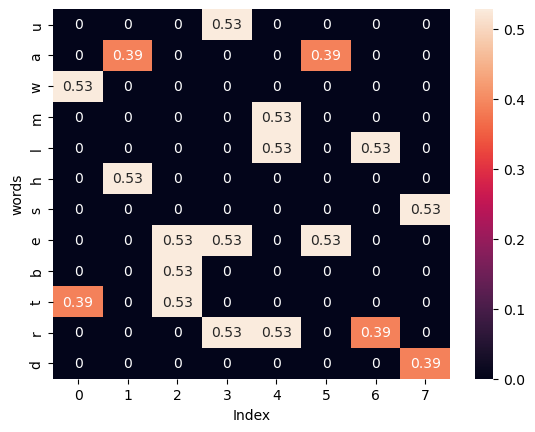

In [164]:
l1 = ['thermals', 'watererd','tabulard']
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")
plt.show()

In [170]:
entrophy_sum = []
entrophy_sum_dic = {}
for i in df.columns:
    entrophy_sum.append(df[i].sum())
    entrophy_sum_dic[i] = df[i].sum()
    
entrophy_sum_dic

{0: 0.9182958340544896,
 1: 0.9182958340544896,
 2: 1.584962500721156,
 3: 1.584962500721156,
 4: 1.584962500721156,
 5: 0.9182958340544896,
 6: 0.9182958340544896,
 7: 0.9182958340544896}

# Building Algorithm

In [ ]:
import random

class HangmanGame:
    def __init__(self, word_list):
        self.word_list = word_list
        self.target_word = ""
        self.guesses_left = 6
        self.guessed_letters = set()
        self.word_in_progress = []
        self.guess_counter = 0

    def choose_word(self):
        self.target_word = random.choice(self.word_list)
        self.word_in_progress = ["_"] * len(self.target_word)

    def display_word(self):
        return " ".join(self.word_in_progress)
    
    def guess_here(self):
        #First find the sorted list as per the length
        same_length_list = [word for word in self.word_list if len(word) == len(self.word_in_progress)]
        
        #
        #First calculate the entrophy of each letter of the words based on the position in the list
        #
        
        #Calculating Entrophy function
        
        def entrophy(letter, position, l1,all_letters):
    
            my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}


            for j in all_letters:
                for i in l1:
                    for k in range(len(i)):
                        if j in i[k]:
                            my_dic[j][k] += 1
            probab = my_dic[letter][position]/len(l1)
            if probab == 0:
                return 0  # To avoid math domain error for log(0)
            entropy = -probab * math.log(probab, 2)
            return entropy

        def Predictor(l1):
            all_letters = list(set("".join(l1)))
            my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
            for i in all_letters:
                for j in range(0,len(l1[0])):
                    my[i][j] = entrophy(i,j,l1,all_letters) 
            df = pd.DataFrame(list(my.values()))
            df['words'] = list(my)
            df = df.set_index('words')
            max_value = df.max().max()
            row,column = np.where(df.values == df.values.max())
            predicted_alphabets = df.index[row[0]]
            col_index = df.columns[column[0]]
            return predicted_alphabets, col_index
        
        #Initial guess based on entrophy
        while self.guess_counter == 0:
            alphabet, col_index = Predictor(same_length_list)
            return alphabet
        
        # Sorting the initial list and guess based on that
        alphabet, col_index = Predictor(same_length_list)
        if self.word_in_progress[col_index] == alphabet:
            return "a"
        else:
            return "z"
        
        
        
        
        
        
        
        
        
        
        
        
        

    def make_guess(self, letter):
        self.guess_counter += 1
        if letter in self.guessed_letters:
            return "You already guessed that letter!"

        self.guessed_letters.add(letter)

        if letter in self.target_word:
            for i in range(len(self.target_word)):
                if self.target_word[i] == letter:
                    self.word_in_progress[i] = letter
            if "_" not in self.word_in_progress:
                return "Congratulations! You guessed the word: {}".format(self.target_word)
        else:
            self.guesses_left -= 1
            if self.guesses_left == 0:
                return "Sorry, you ran out of guesses. The word was: {}".format(self.target_word)

        return self.display_word() + f"\nLives left: {self.guesses_left}"

# Example usage:
word_list = all_words

custom_hangman = HangmanGame(word_list)
custom_hangman.choose_word()

print("Welcome to Hangman!")
print("Word to guess:", custom_hangman.display_word())

while custom_hangman.guesses_left > 0 and "_" in custom_hangman.word_in_progress:
    #guess = input("Enter your guess: ").lower()
    guess = custom_hangman.guess_here()
    result = custom_hangman.make_guess(guess)
    print(result)

print("Game over.")


Welcome to Hangman!
Word to guess: _ _ _ _ _ _ _ _


# New Game

In [172]:
six_letter_word = [word for word in all_words if len(word) == 6]
six_letter_word

['aaaaaa',
 'aachen',
 'aaliis',
 'aarika',
 'abacas',
 'abakas',
 'abanet',
 'abanic',
 'abaris',
 'abased',
 'abasgi',
 'abated',
 'abatic',
 'abatis',
 'abator',
 'abayah',
 'abbacy',
 'abbate',
 'abbaye',
 'abbeys',
 'abbots',
 'abboud',
 'abdest',
 'abdiel',
 'abduce',
 'abeigh',
 'abeles',
 'aberia',
 'abesse',
 'abhors',
 'abided',
 'abigei',
 'abilao',
 'abilla',
 'abisag',
 'abject',
 'abjure',
 'abkari',
 'abkhas',
 'ablast',
 'ablate',
 'ablaut',
 'ablaze',
 'ablend',
 'ablock',
 'ablude',
 'ablute',
 'abomas',
 'abongo',
 'aborad',
 'aborts',
 'abouts',
 'aboves',
 'abrade',
 'abramo',
 'abrash',
 'abrazo',
 'abrege',
 'abroma',
 'abrook',
 'abrupt',
 'abscam',
 'absist',
 'absohm',
 'absorb',
 'absume',
 'absurd',
 'abucco',
 'abukir',
 'aburst',
 'abused',
 'abusee',
 'abuser',
 'abuses',
 'abvolt',
 'abydos',
 'abying',
 'abysms',
 'abyssa',
 'acacia',
 'acacin',
 'acadia',
 'acaena',
 'acalia',
 'acamar',
 'acampo',
 'acarus',
 'acater',
 'acates',
 'accend',
 'accent',

In [174]:
TARGET_word = schmoe

19541

# My Algorithm

# Starting the game

Text(0.5, 23.52222222222222, 'Index')

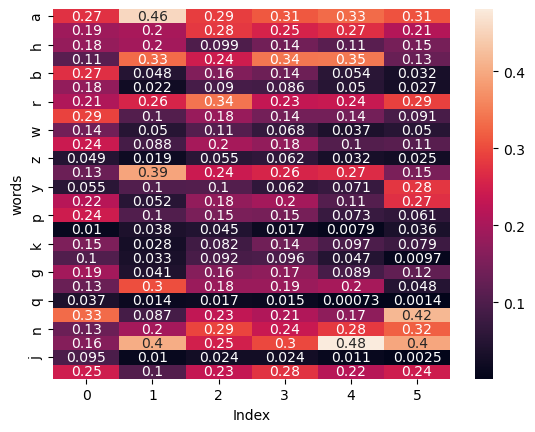

In [176]:
l1 = six_letter_word
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [ ]:
now my next guess is "e" at fourth position
TARGET_word = schmoe
Right GUESS
LIVES LEFT: 6
But not at fourth position

In [185]:
filtered_words = []
for i in six_letter_word:
    if i[4] != "e" and i[5] == "e":
        filtered_words.append(i)

In [186]:
len(filtered_words)

2552

In [ ]:
## Next guess

Text(0.5, 23.52222222222222, 'Index')

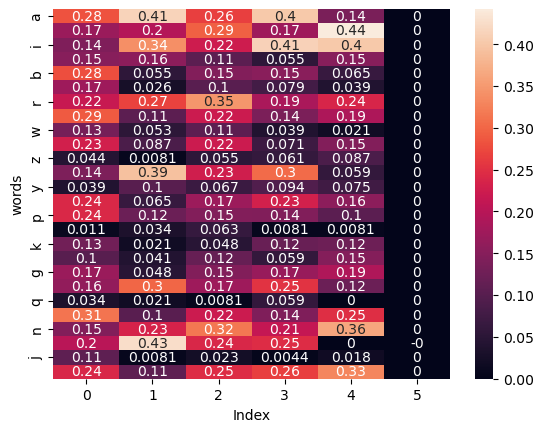

In [187]:
l1 = filtered_words
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [ ]:
now my next guess is "l" at fourth position
TARGET_word = schmoe
Wrong GUESS
LIVES LEFT: 5


In [ ]:
#Next guess

In [196]:
next_filtered_words = []
for i in filtered_words:
    
    if i[4] != "l" and "l" not in i:
        next_filtered_words.append(i)

In [197]:
len(next_filtered_words)

1664

Text(0.5, 23.52222222222222, 'Index')

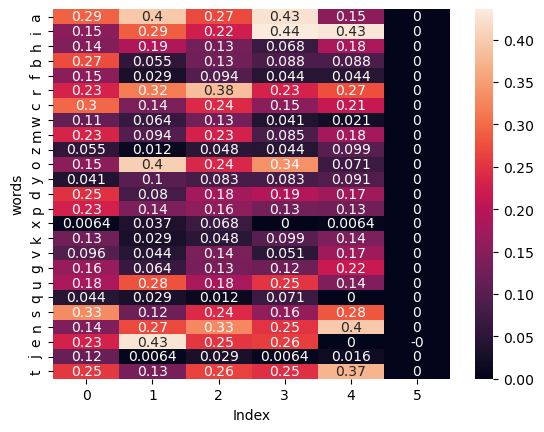

In [198]:
l1 = next_filtered_words
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [ ]:
now my next guess is "i" at third index
TARGET_word = schmoe
Wrong GUESS
LIVES LEFT: 4

In [ ]:
#Next guess

In [199]:
next_next_filtered_words = []
for i in next_filtered_words:
    if i[3] != "i" and "i" not in i:
        next_next_filtered_words.append(i)
len(next_next_filtered_words)

901

Text(0.5, 23.52222222222222, 'Index')

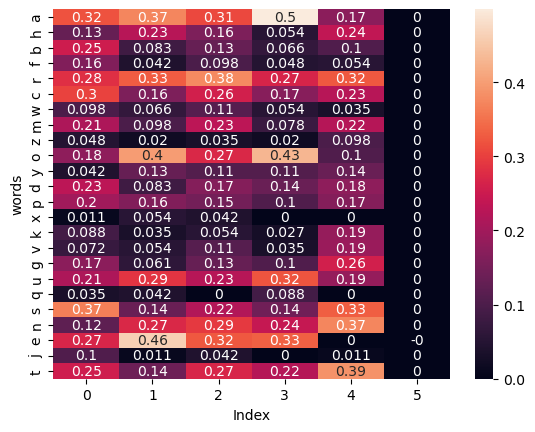

In [200]:
l1 = next_next_filtered_words
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [ ]:
now my next guess is "a" at third index
TARGET_word = schmoe
Wrong GUESS
LIVES LEFT: 3

In [ ]:
#NEXT GUESS

In [210]:
next_next_next_filtered_words = []
for i in next_next_filtered_words:
    if i[3] != "a" and "a" not in i:
        next_next_next_filtered_words.append(i)
len(next_next_next_filtered_words)

442

Text(0.5, 23.52222222222222, 'Index')

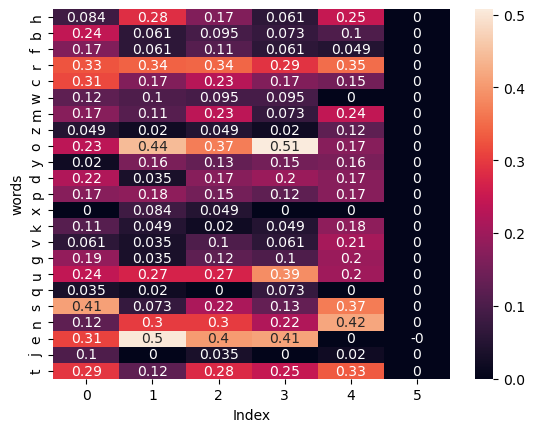

In [202]:
l1 = next_next_next_filtered_words
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [ ]:
now my next guess is "o" at third index
TARGET_word = schmoe
Right GUESS
LIVES LEFT: 3
but not on that index

In [203]:
#Next Guess

In [213]:
next_next_next_next_filtered_words = []
for i in next_next_next_filtered_words:
    if i[3] != "o" and i[4] == "o":
        next_next_next_next_filtered_words.append(i)
len(next_next_next_next_filtered_words)

16

Text(0.5, 23.52222222222222, 'Index')

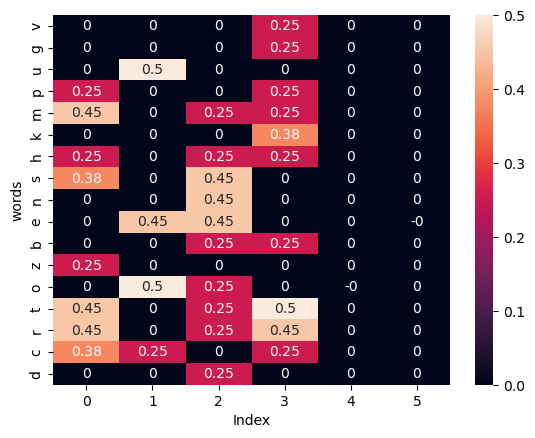

In [217]:
l1 = next_next_next_next_filtered_words
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [219]:
print(df[1].sum())
print(df[2].sum())
print(df[3].sum())

1.7028195311147831
3.1084585933443494
3.077819531114783


In [ ]:
now my next guess is "t" at third index
TARGET_word = schmoe
Wrong GUESS
LIVES LEFT: 2


In [ ]:
#Next Guess

In [224]:
Last_Guess = []
for i in next_next_next_next_filtered_words:
    if i[3] != "t" and "t" not in i:
        Last_Guess.append(i)
len(Last_Guess)

11

Text(0.5, 23.52222222222222, 'Index')

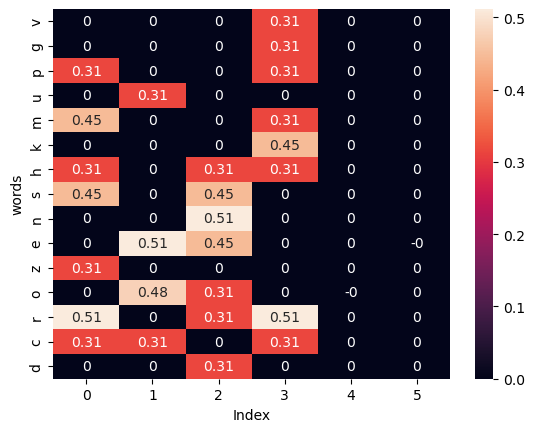

In [225]:
l1 = Last_Guess
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [226]:
print(df[0].sum())
print(df[1].sum())
print(df[2].sum())
print(df[3].sum())

2.663532754804255
1.6171895725927152
2.663532754804255
2.845350936622437


In [ ]:
now my next guess is "r" at third index
TARGET_word = schmoe
Wrong GUESS
LIVES LEFT: 1

In [ ]:
#Next Guess

In [227]:
Last_Guess_to_last = []
for i in Last_Guess:
    if i[3] != "r" and "r" not in i:
        Last_Guess_to_last.append(i)
len(Last_Guess_to_last)

5

Text(0.5, 23.52222222222222, 'Index')

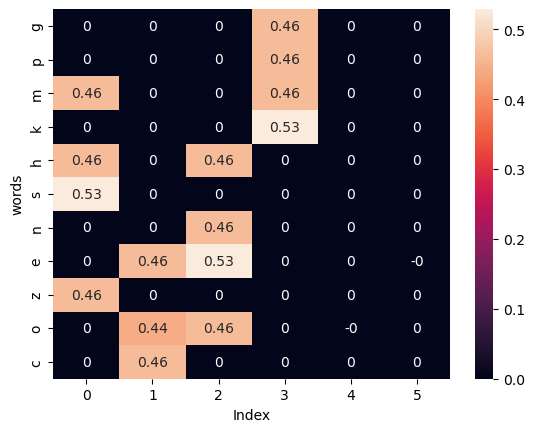

In [228]:
l1 = Last_Guess_to_last
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [229]:
print(df[0].sum())
print(df[1].sum())
print(df[2].sum())
print(df[3].sum())

1.9219280948873623
1.3709505944546687
1.9219280948873623
1.9219280948873623


In [ ]:
now my next guess is "s" at zero index
TARGET_word = schmoe
Right GUESS
LIVES LEFT: 1

In [ ]:
#Next Guess

In [232]:
last_live = []
for i in Last_Guess_to_last:
    if i[0] == "s":
        last_live.append(i)
len(last_live)

2

Text(0.5, 23.52222222222222, 'Index')

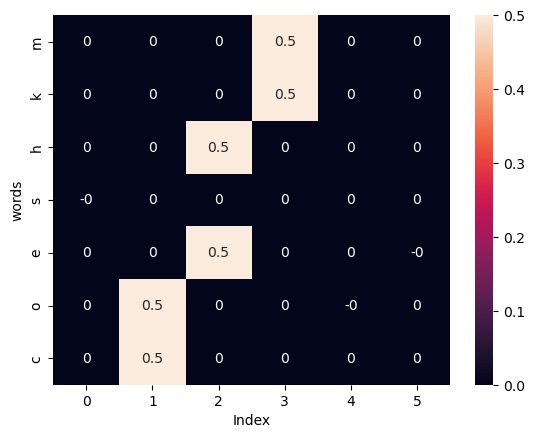

In [233]:
l1 = last_live
all_letters = list(set("".join(l1)))
def entrophy(letter, position):
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
for i in all_letters:
    for j in range(0,len(l1[0])):
        my[i][j] = entrophy(i,j) 
df = pd.DataFrame(list(my.values()))
df['words'] = list(my)
df = df.set_index('words')
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [ ]:
now my next guess is "s" at zero index
TARGET_word = schmoe
Right GUESS
LIVES LEFT: 1

In [234]:
last_live

['schmoe', 'soekoe']

# Game 2

# Alphabet Calculator

In [154]:
def entrophy(letter, position, l1,all_letters):
    #all_letters = list(set("".join(l1)))
    my_dic = {letter: {position: 0 for position in range(len(l1[0]))} for letter in all_letters}
    

    for j in all_letters:
        for i in l1:
            for k in range(len(i)):
                if j in i[k]:
                    my_dic[j][k] += 1
    probab = my_dic[letter][position]/len(l1)
    if probab == 0:
        return 0  # To avoid math domain error for log(0)
    entropy = -probab * math.log(probab, 2)
    return entropy

def letters_entrophy_df(l1):
    all_letters = list(set("".join(l1)))
    my = {letter: {position: 0 for position in range(0,len(l1[0]))} for letter in all_letters}
    for i in all_letters:
        for j in range(0,len(l1[0])):
            my[i][j] = entrophy(i,j,l1,all_letters) 
    df = pd.DataFrame(list(my.values()))
    df['words'] = list(my)
    df = df.set_index('words')
    max_value = df.max().max()
    row,column = np.where(df.values == df.values.max())
    predicted_alphabets = df.index[row[0]]
    col_index = df.columns[column[0]]
    return sns.heatmap(df,annot = True),predicted_alphabets, col_index

# Target Word - prevaricators

In [ ]:
# Target word = prevaricators
# Lives Left = 6
# _____________
# 13 letter word

In [158]:
thirteen_letter_words = [word for word in all_words if len(word) == 13]

Predicted_Alphabets is i on index = 10


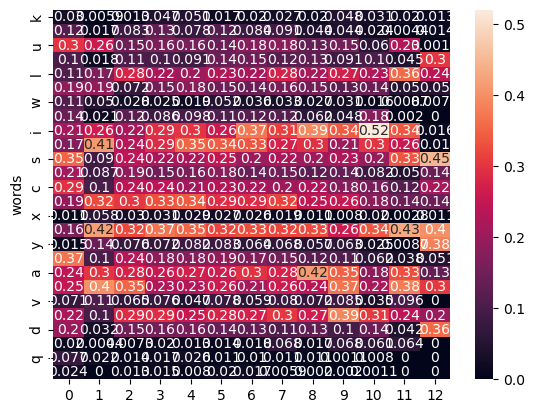

In [159]:
df,predicted_alphabets, col_index = letters_entrophy_df(thirteen_letter_words)
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")


In [ ]:
# Target word = prevaricators
# Predicted word = i but not on index 10
# Lives Left = 6
# ______i______
# 13 letter word

Previous List length is 12956 and Now it is 435
Predicted_Alphabets is e on index = 10


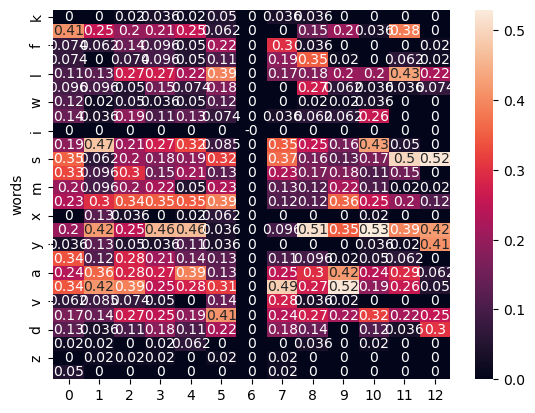

In [181]:
second_list = [words for words in thirteen_letter_words if "i" not in words[:6] and "i" not in words[6+1:] and words[6] == 'i']
df,predicted_alphabets, col_index = letters_entrophy_df(second_list)
print(f"Previous List length is {len(thirteen_letter_words)} and Now it is {len(second_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")


In [ ]:
# Target word = prevaricators
# Predicted word = s and on index 12
# Lives Left = 6
# ______i_____s
# 13 letter word

Previous List length is 973 and Now it is 112
Predicted_Alphabets is f on index = 7


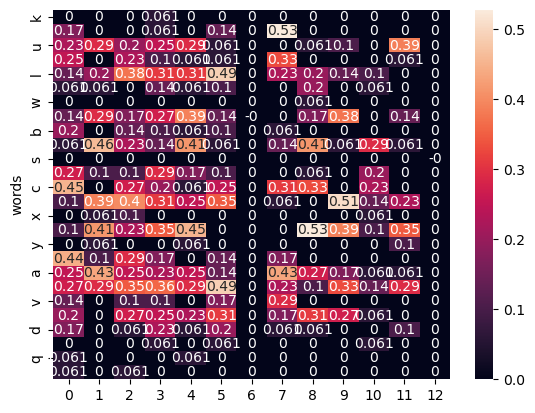

In [170]:
third_list = [words for words in second_list if words[12] == 's' and "s" not in words[:12]]
df,predicted_alphabets, col_index = letters_entrophy_df(third_list)
print(f"Previous List length is {len(second_list)} and Now it is {len(third_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [ ]:
# Target word = prevaricators
# Predicted word = f NOT in Target word
# Lives Left = 6 -1 = 5
# ______i_____s
# 13 letter word

Previous List length is 112 and Now it is 69
Predicted_Alphabets is n on index = 5


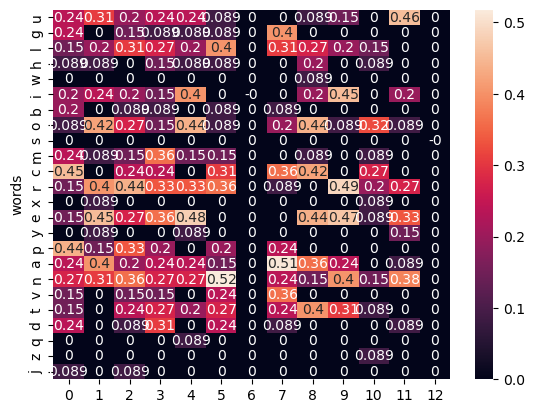

In [171]:
fourth_list = [words for words in third_list if "f" not in words]
df,predicted_alphabets, col_index = letters_entrophy_df(fourth_list)
print(f"Previous List length is {len(third_list)} and Now it is {len(fourth_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [ ]:
# Target word = prevaricators
# Predicted word = n NOT in Target word
# Lives Left = 5 - 1 = 4
# ______i_____s
# 13 letter word

Previous List length is 69 and Now it is 16
Predicted_Alphabets is l on index = 5


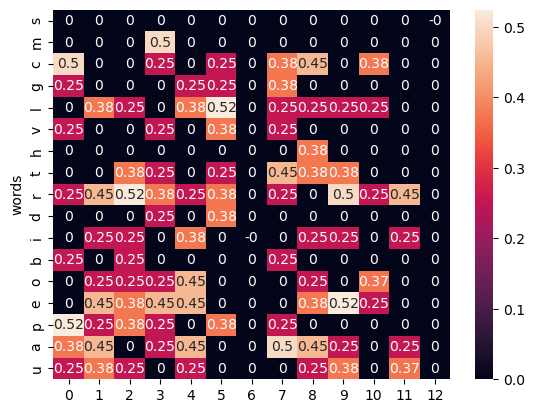

In [172]:
fifth_list = [words for words in fourth_list if "n" not in words]
df,predicted_alphabets, col_index = letters_entrophy_df(fifth_list)
print(f"Previous List length is {len(fourth_list)} and Now it is {len(fifth_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [ ]:
# Target word = prevaricators
# Predicted word = l NOT in Target word
# Lives Left = 4 - 1 = 3
# ______i_____s
# 13 letter word

Previous List length is 16 and Now it is 5
Predicted_Alphabets is t on index = 7


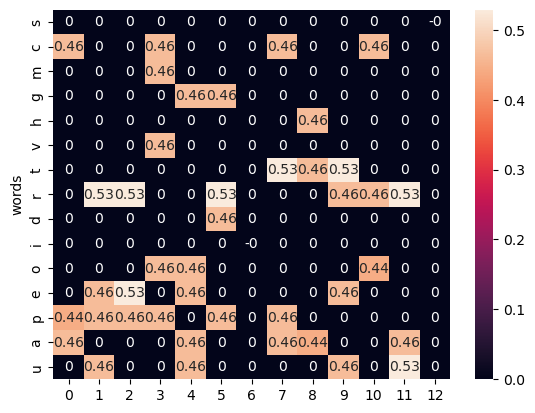

In [173]:
sixth_list = [words for words in fifth_list if "l" not in words]
df,predicted_alphabets, col_index = letters_entrophy_df(sixth_list)
print(f"Previous List length is {len(fifth_list)} and Now it is {len(sixth_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [ ]:
# Target word = prevaricators
# Predicted word = t NOT 7th Index
# Lives Left = 3
# ______i__t__s
# 13 letter word

Previous List length is 5 and Now it is 2
Predicted_Alphabets is m on index = 3


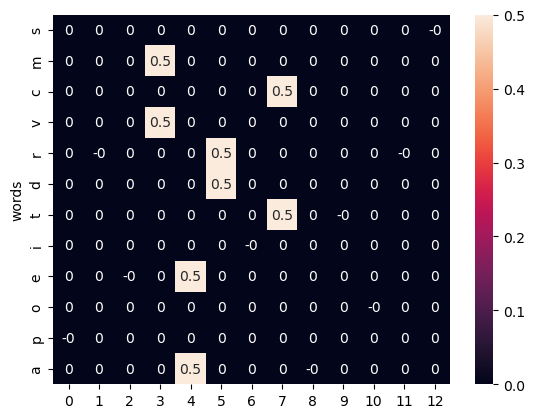

In [176]:
seventh_list = [words for words in sixth_list if words[9] == "t" and words[:9] != "t" and words[9+1:] != "t"]
df,predicted_alphabets, col_index = letters_entrophy_df(seventh_list)
print(f"Previous List length is {len(sixth_list)} and Now it is {len(seventh_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [177]:
# Target word = prevaricators
# Predicted word = m NOT in the target word
# Lives Left = 3 - 1 = 2
# ______i__t__s
# 13 letter word

['premeditators', 'prevaricators']

Previous List length is 2 and Now it is 1
Predicted_Alphabets is s on index = 0


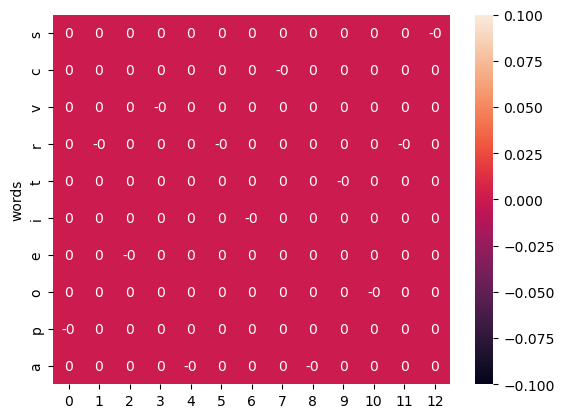

In [178]:
eighth_list = [words for words in seventh_list if "m" not in words]
df,predicted_alphabets, col_index = letters_entrophy_df(eighth_list)
print(f"Previous List length is {len(seventh_list)} and Now it is {len(eighth_list)}")
print(f"Predicted_Alphabets is {predicted_alphabets} on index = {col_index}")

In [138]:
list(my)

['a', 'w', 'm', 'l', 'h', 's', 'r', 'n', 'b', 'e', 't', 'o', 'd']

Text(0.5, 23.52222222222222, 'Index')

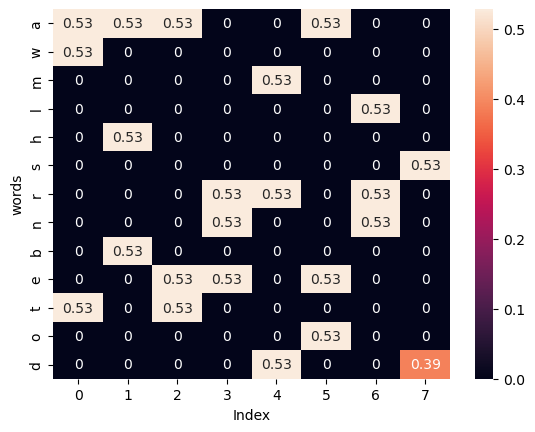

In [153]:
import seaborn as sns
sns.heatmap(df,annot= True,cbar = 'coolwarm' )
plt.xlabel("Index")

In [103]:
dict(sorted(my['a'].items(),reverse = True, key = lambda x:x[1]))

{0: 0.5283208335737187,
 1: 0.5283208335737187,
 2: 0.5283208335737187,
 5: 0.5283208335737187,
 3: 0,
 4: 0,
 6: 0,
 7: 0}

In [92]:
my.values()

dict_values([{0: 0.5283208335737187, 1: 0.5283208335737187, 2: 0.5283208335737187, 3: 0, 4: 0, 5: 0.5283208335737187, 6: 0, 7: 0}, {0: 0.5283208335737187, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}, {0: 0, 1: 0, 2: 0, 3: 0, 4: 0.5283208335737187, 5: 0, 6: 0, 7: 0}, {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0.5283208335737187, 7: 0}, {0: 0, 1: 0.5283208335737187, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}, {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0.5283208335737187}, {0: 0, 1: 0, 2: 0, 3: 0.5283208335737187, 4: 0.5283208335737187, 5: 0, 6: 0.5283208335737187, 7: 0}, {0: 0, 1: 0, 2: 0, 3: 0.5283208335737187, 4: 0, 5: 0, 6: 0.5283208335737187, 7: 0}, {0: 0, 1: 0.5283208335737187, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}, {0: 0, 1: 0, 2: 0.5283208335737187, 3: 0.5283208335737187, 4: 0, 5: 0.5283208335737187, 6: 0, 7: 0}, {0: 0.5283208335737187, 1: 0, 2: 0.5283208335737187, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}, {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0.5283208335737187, 6: 0, 7: 0}, {0: 0, 1: 0, 2: 0, 3: 0, 4: 0.

In [ ]:
['abandond', 'thermals', 'watererd']

In [ ]:
Position 1
Entropy of a 
- 1/5 * math.log(1/5,2) = 0.4644
Entropy of u 
0
Entropy of w 
- 1/5 * math.log(1/5,2) = 0.4644

Entropy of m
0
Entropy of k 
- 1/5 * math.log(1/5,2) = 0.4644


Entropy of i 
0
Entropy of h 
0
Entropy of s 
0
Entropy of r 
0
Entropy of l
0
Entropy of n
- 1/5 * math.log(1/5,2) = 0.4644

Entropy of b
0

Entropy of e
0

Entropy of t
- 1/5 * math.log(1/5,2) = 0.4644


Entropy of o
0

Entropy of d
0



In [ ]:
Position 2
Entropy of a 
-3/5 * math.log(3/5,2) = 0.4421

Entropy of u 
0
Entropy of w 
- 1/5 * math.log(1/5,2) = 0.4644

Entropy of m
0
Entropy of k 
- 1/5 * math.log(1/5,2) = 0.4644


Entropy of i 
0
Entropy of h 
0
Entropy of s 
0
Entropy of r 
0
Entropy of l
0
Entropy of n
- 1/5 * math.log(1/5,2) = 0.4644

Entropy of b
0

Entropy of e
0

Entropy of t
- 1/5 * math.log(1/5,2) = 0.4644


Entropy of o
0

Entropy of d
0



In [14]:
-3/5 * math.log(3/5,2)


0.44217935649972373

['u',
 'a',
 'w',
 'm',
 'k',
 'i',
 'h',
 's',
 'r',
 'l',
 'n',
 'b',
 'e',
 't',
 'o',
 'd']

In [3]:
import math

In [6]:
- 1/5 * math.log(1/5,2)

0.46438561897747244

Number of words in the game: 227300


In [170]:
all_words = l1[0]

In [169]:
len(l1[0])

227300

In [130]:
def count_sorted_list(word):
    new_dic = {}
    for i in word:
        if i not in new_dic:
            new_dic[i] = 1
        else:
            new_dic[i] +=1
    new_dic = list(dict((sorted(new_dic.items(),reverse = True,key = lambda x:x[1]))).keys())
    return new_dic

d1 = count_sorted_list("hangman")

d1      

['a', 'n', 'h', 'g', 'm']

In [116]:
d1[1]

KeyError: 1

In [41]:
word = 'hangmn'
word_in_progress = ["_"] * 6
word_in_progress

['_', '_', '_', '_', '_', '_']

In [110]:
word_list = ["pythona", "hangman", "codinga", "challea", "gamedaa"]

word_in_progress = ["_"] * 7
word_in_progress[1] = "y"


incomplete_word = "".join(word_in_progress)
#Find all the same length words from the final_list to predict the next letter
words_with_same_length = [char for char in word_list if len(char) == len(word_in_progress)]

# Convert them into vectors using CountVectorizer
vectorizer = CountVectorizer(analyzer = 'char')
words_with_same_length_vector = vectorizer.fit_transform(words_with_same_length)
incomplete_word_vector = vectorizer.transform([incomplete_word])


similarities = cosine_similarity(words_with_same_length_vector, incomplete_word_vector)

similar_dic = {}
for i,j in enumerate(similarities.tolist()):
    similar_dic[i] = j[0]
    
sorted_list = sorted(similar_dic.items(),key = lambda x:x[1],reverse = True)

similar_values = [words_with_same_length[sorted_list[i][0]] for i in range(len(sorted_list))]
print(similar_values)

['pythona', 'hangman', 'codinga', 'challea', 'gamedaa']


In [107]:
for i in range(len(sorted_list)):
    print(words_with_same_length[sorted_list[i][0]])

challea
hangman
gamedaa
pythona
codinga


In [108]:
[words_with_same_length[sorted_list[i][0]] for i in range(len(sorted_list))]

['challea', 'hangman', 'gamedaa', 'pythona', 'codinga']

In [101]:
words_with_same_length

['pythona', 'hangman', 'codinga', 'challea', 'gamedaa']

In [96]:
similar_dic

{0: 0.3779644730092272,
 1: 0.30151134457776363,
 2: 0.0,
 3: 0.30151134457776363,
 4: 0.0}

In [97]:
words_with_same_length

['pythona', 'hangman', 'codinga', 'challea', 'gamedaa']

In [93]:
sorted_list

[(0, 0.30151134457776363), (1, 0.3333333333333333)]

In [99]:
sorted_list

[(0, 0.3779644730092272),
 (1, 0.30151134457776363),
 (3, 0.30151134457776363),
 (2, 0.0),
 (4, 0.0)]

In [49]:
similarities = np.vstack([similarities, np.array([0.1])])
similarities

array([[0.28867513],
       [0.57735027],
       [0.1       ]])

In [71]:
similar_dic = {}
for i,j in enumerate(similarities.tolist()):
    similar_dic[i] = j[0]
    
similar_dic

{0: 0.2886751345948129, 1: 0.5773502691896258}

In [69]:
sorted(similar_dic.items(),key = lambda x:x[1])

[(2, 0.1), (0, 0.2886751345948129), (1, 0.5773502691896258)]

In [72]:
words_with_same_length[sorted(similar_dic.items(),key = lambda x:x[1])[0][0]]

'python'

In [50]:
sorted(similarities.tolist())

[[0.1], [0.2886751345948129], [0.5773502691896258]]

In [25]:
words_with_same_length

['python', 'coding']

In [33]:
np.sort(similarities,axis = 0)[::-1]

array([[0.57735027],
       [0.28867513]])

In [41]:
np.argsort(similarities,axis = 0,kind = 'mergesort')

array([[4],
       [0],
       [1],
       [2],
       [3]], dtype=int64)